In [0]:
!unzip  test.zip
!unzip  train.zip
!unzip  validation.zip

In [25]:
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras import models
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import PIL.Image

'''
データの設定
'''
batch_size = 16
# 全ての画像を1/255でスケーリング
train_datagen = ImageDataGenerator(     # データの拡張
    rescale= 1./255,
    rotation_range= 40,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    shear_range= 0.2,
    horizontal_flip= True,
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory= "train",      # ターゲットディレクトリ
    target_size= (150, 150),                                            # 全ての画像のサイズを(150, 150)に変更
    batch_size= batch_size, # バッチサイズ
    class_mode= "binary"    # binary_crossentropyを使用するため二値のラベルが必要
)

validation_generator = test_datagen.flow_from_directory(
    directory= "validation",
    target_size= (150, 150),
    batch_size= batch_size,
    class_mode= "binary"
)

'''
モデルの構築
'''
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
# model.summary()
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"])

'''
学習
'''
early_stopping = EarlyStopping(monitor= "val_loss", patience= 10, verbose= 1)
batch_size = 32

history = model.fit_generator(
    train_generator,
    steps_per_epoch= 3200 // batch_size,
    epochs= 100,
    validation_data= validation_generator,
    validation_steps= 50,
    callbacks= [early_stopping]
)
model.save("cats_and_dogs_small_2.h5")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 19s 187ms/step - loss: 0.7150 - acc: 0.5181 - val_loss: 0.6922 - val_acc: 0.5025
Epoch 2/100
100/100 [==============================] - 17s 167ms/step - loss: 0.6995 - acc: 0.5281 - val_loss: 0.6817 - val_acc: 0.5694
Epoch 3/100
100/100 [==============================] - 17s 167ms/step - loss: 0.7061 - acc: 0.5719 - val_loss: 0.6639 - val_acc: 0.5467
Epoch 4/100
100/100 [==============================] - 17s 168ms/step - loss: 0.6798 - acc: 0.5725 - val_loss: 0.6500 - val_acc: 0.6174
Epoch 5/100
100/100 [==============================] - 17s 167ms/step - loss: 0.6674 - acc: 0.6050 - val_loss: 0.6271 - val_acc: 0.6625
Epoch 6/100
100/100 [==============================] - 17s 168ms/step - loss: 0.6590 - acc: 0.6250 - val_loss: 0.6072 - val_acc: 0.6755
Epoch 7/100
100/100 [==============================] - 17s 166ms/step - loss: 0.6502 - acc: 0.6300 -

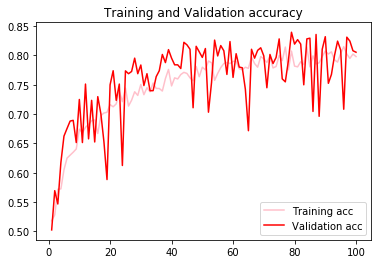

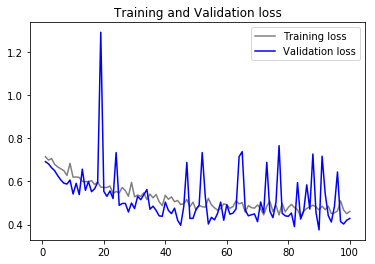

In [26]:
'''
評価
'''
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label="Training acc", color= "pink")
plt.plot(epochs, val_acc, label="Validation acc", color= "red")
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, label="Training loss", color= "gray")
plt.plot(epochs, val_loss, label="Validation loss", color= "blue")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

回答ありがとうございます。
ある程度は実際撮影される環境と近しいものをイメージして水増しすべきという感じでしょうか。
またkerasのドキュメントを読んでも確認する方法が分からなかったのですが、例えば訓練データが１００枚あったとして、質問欄に記載したコードのようにImageDataGeneratorでパラメータを指定して作成したジェネレータを、flow_from_directoryに渡してデータを水増しした場合、結果１００枚→何枚のデータが作成されるのでしょうか？

パラメータに従ってリアルタイムに変換するので、予め n 倍に増やすというわけではないです。
例えば、全データが9枚でバッチサイズが3だとしたら、
ImageDataGenerator を使わない場合は、3枚で1バッチとしてネットワークに流しますよね。
ImageDataGenerator を使う場合は、3枚取り出したあと、パラメータに従いランダムな変換を行い、1バッチ作成します。

生成された画像は
flow_from_directory() の引数 save_to_dir に出力先のディレクトリを指定しておくと、実際どんな画像がネットワークに流れたのか確認できます。 

なるほど。。。
ではImageDataGenerator を使う場合は元の訓練データとしての状態は維持されない(すべて変換された画像になる)ということでしょうか。
水増しというのは画像の枚数を増やすことだとばかり理解していたのですが、そうではなく様々な形状を学習させることで表現力を上げる(ロバスト性？)ということが本来の目的ということでしょうか？
また重ねて質問して申し訳ないのですがImageDataGenerator で複数のパラメータを指定した場合(例えば回転、水平移動、ズームの３つ)は回転だけ適応された画像、回転とズームが適応された画像、のように様々なパターンの画像が出来ると解釈しているのですが、この組み合わせは完全ランダムでしょうか？ 

> (すべて変換された画像になる)ということでしょうか。

ランダムです。例えば、回転だけ設定したとして、ランダムに角度を決めたときにたまたま0°であれば、元と同じ画像が使われますが、そうでなければ変換された元とは異なる画像になります。

> 様々な形状を学習させることで表現力を上げるということが本来の目的ということでしょうか？

そうなります。なので、予め n 倍に増やすかどうかは本質ではないです。

> この組み合わせは完全ランダムでしょうか？

完全にランダムです。
回転をどのくらいするか、水平移動をどのくらいするかというのはそれぞれ独立に決まります。なので、回転して、平行移動して、ズームしてといったすべての変換が基本的に行われると思って良いです。

詳しい挙動はソースに書いてあります。
https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/image_data_generator.***py***

https://teratail.com/questions/177623#reply-264243
